In [1]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential,load_model
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from livelossplot.inputs.tf_keras import PlotLossesCallback
from keras import layers
from keras import backend as K
from sklearn.metrics import confusion_matrix
from keras.regularizers import l2

import dataset_preprocessing as dp
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras
%matplotlib inline

In [2]:
pics,emo, df = dp.dataset_loader()
pics = dp.preprocess(pics)

In [3]:
#Defining of parameters
l2_regularization=0.01
batch_size = 32
num_epochs = 150
input_shape = (48, 48, 1)
verbose = 1
num_classes = 7
patience = 50
path = 'elu/models/'
l2_reg=0.01
height = 48
width = 48

#splitting of the dataset into 80% for training and 20% from validation
X_train,X_test,train_y,test_y = train_test_split(pics, emo,test_size=0.2,shuffle=True)

In [4]:
def create_model():
    regularization = l2(l2_reg)
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    residual = Conv2D(16, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    residual = Conv2D(32, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    residual = Conv2D(64, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    residual = Conv2D(128, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])
    x = Conv2D(num_classes, (3, 3), padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax',name='predictions')(x)

    model = Model(img_input, output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy',dp.f1_score,dp.precision_m, dp.recall_m])
#     model.summary()
    return model

In [5]:
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 46, 46, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 46, 46, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 46, 46, 8)    0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [5]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

# callbacks
log_file_path = path + 'elu.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/4), verbose=1)
trained_models_path = path + '_mini_XCEPTION'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
callbacks = [PlotLossesCallback(),model_checkpoint, csv_logger, early_stop, reduce_lr]

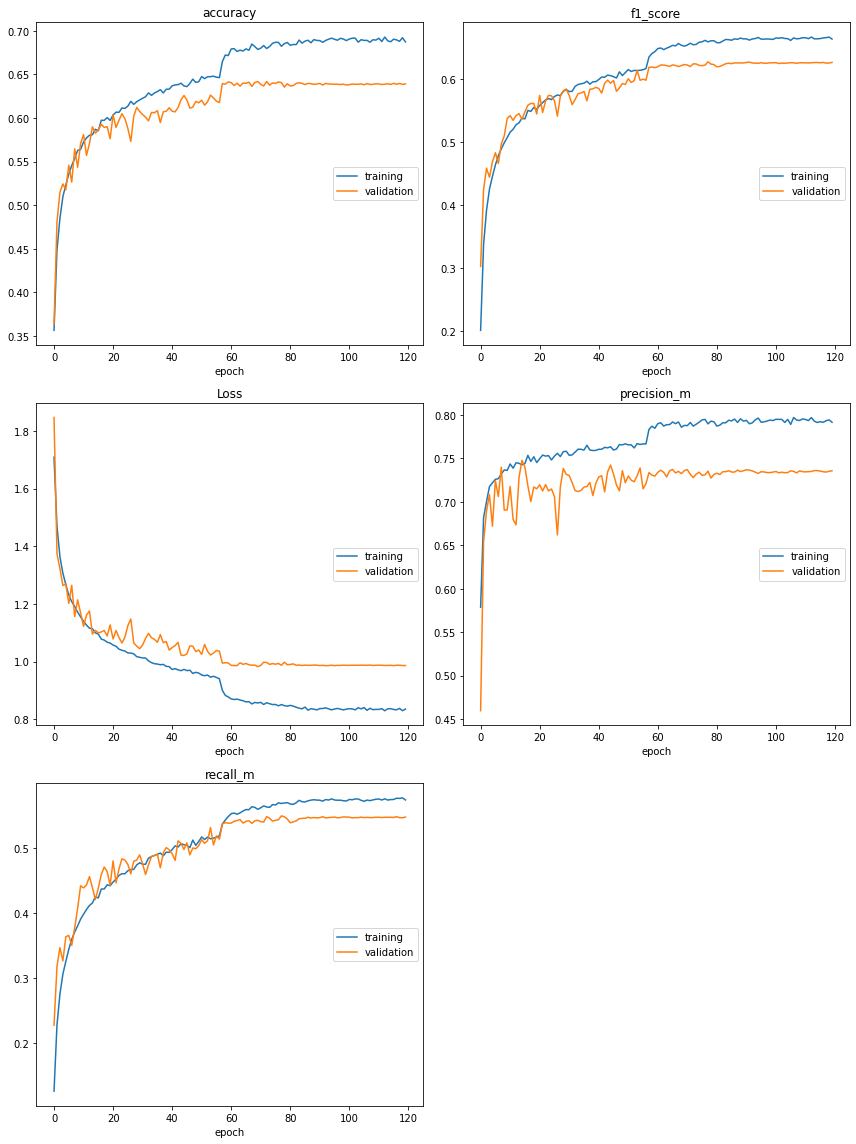

accuracy
	training         	 (min:    0.357, max:    0.693, cur:    0.687)
	validation       	 (min:    0.364, max:    0.642, cur:    0.639)
f1_score
	training         	 (min:    0.201, max:    0.667, cur:    0.663)
	validation       	 (min:    0.302, max:    0.627, cur:    0.626)
Loss
	training         	 (min:    0.830, max:    1.709, cur:    0.835)
	validation       	 (min:    0.982, max:    1.847, cur:    0.987)
precision_m
	training         	 (min:    0.579, max:    0.797, cur:    0.791)
	validation       	 (min:    0.460, max:    0.748, cur:    0.736)
recall_m
	training         	 (min:    0.127, max:    0.577, cur:    0.574)
	validation       	 (min:    0.228, max:    0.549, cur:    0.548)

Epoch 00120: val_loss did not improve from 0.98250


In [7]:
model.fit_generator(data_generator.flow(xtrain, ytrain,batch_size),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=num_epochs, verbose=1, callbacks=callbacks,
                        validation_data=(xtest,ytest))

In [13]:
path = 'models/'
model_export = model.to_json()
with open(path + "elu.json", "w") as json_file:
    json_file.write(model_export)
model.save_weights(path + "elu.h5")

In [6]:
import os
import cv2
import numpy as np
from keras.models import model_from_json
from keras.preprocessing import image
from keras.models import load_model
# Importing model
model = create_model()
model.load_weights('models/elu.h5')

In [7]:
evalutaion = model.evaluate(np.array(X_test), np.array(test_y))
print("" )
print("" )
print("**************Result**************" )
print("Loss: " + str(evalutaion[0]))
print("Accuracy: " + str(evalutaion[1]))
print("F1 Score: " + str(evalutaion[2]))
print("Precision: " + str(evalutaion[3]))
print("**********************************" )

225/225 [==============================] - 5s 17ms/step - loss: 0.8490 - accuracy: 0.6902 - f1_score: 0.6750 - precision_m: 0.7813 - recall_m: 0.5964


**************Result**************
Loss: 0.8405066728591919
Accuracy: 0.6887712478637695
F1 Score: 0.6723604798316956
Precision: 0.7813402414321899
**********************************


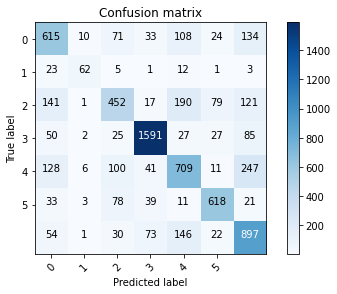

In [10]:
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(test_y,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
dp.plot_confusion_matrix(confusion_mtx, classes = range(6))